In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipdb

from tqdm import tqdm_notebook as tqdm

In [2]:
def make_signal(w, theta, n, skip=1, shift=0):
    """
    Assumes normalized amplitude
    """
    t = np.arange(shift,shift+n*skip,skip)
    signal = np.exp(1j*(w*t + theta))
    return signal

def make_noise(sigma2,n):
    noise_scaling = np.sqrt(sigma2/2)
    # noise is complex valued
    noise  = noise_scaling*np.random.randn(n) + 1j*noise_scaling*np.random.randn(n)
    return noise

def make_noisy_signal(w, theta, sigma2, n, skip=1):
    """
    w: frequency in radians per sample
    theta: phase
    sigma2: noise variance
    n: number of samples
    skip: sampling period
    """
    signal = make_signal(w,theta,n,skip)
    noise  = make_noise(sigma2,n)
    return signal + noise

def get_sigma2_from_snrdb(SNR_db):
    return 10**(-SNR_db/10)

def kay_weights(N):
    scaling = 6.0/N/(N**2 - 1)
    w = [(N-i-1)*(i+1) for i in range(N-1)]
    return scaling*np.array(w)



## Kay's methods

In [3]:
def kays_method1(my_signal, simple_average=False):
    """
    This is the implementation in the paper
    """
    N = len(my_signal)

    if simple_average:
        w = np.ones_like(w)
    else:
        w = kay_weights(N)
        
    angle_diff = np.angle(np.conj(my_signal[0:-1])*my_signal[1:])
#     ipdb.set_trace()
    need_to_shift = np.any(angle_diff < -np.pi/2)
    
    omega = w.dot(angle_diff)
    
    if need_to_shift:   
#         print('needed to shift')
        neg_idx = angle_diff < 0
        omega += np.sum(w[neg_idx]*np.pi*2)
    
    return omega

def kays_method2(my_signal, simple_average=False):
    """
    This is my best implementation
    """
    N = len(my_signal)
        
    if not simple_average:
        w = kay_weights(N)
    else:
        w = np.ones_like(w)
        
    # we will check 4 settings
    t = np.arange(N)
    
    v_best = -np.inf
    omega_best = 0
    for k in range(4):
        rotater = np.exp(-1j*np.pi*k*t/2)
        y = my_signal*rotater
        angle_diff = np.angle(np.conj(y[0:-1])*y[1:])
        omega = w.dot(angle_diff)
        
        y_hat = np.exp(1j*omega*t)
        
        v = np.abs(np.dot(y, np.conj(y_hat)))
        if v > v_best:
            omega_best = (omega + k*np.pi/2) % (2*np.pi)
            v_best = v
    
    return omega_best

def kays_method3(my_signal, simple_average=False):
    """
    This is somewhere in between
    """
    N = len(my_signal)

    if simple_average:
        w = np.ones_like(w)
    else:
        w = kay_weights(N)
        
    angle_diff = np.angle(np.conj(my_signal[0:-1])*my_signal[1:])
    
    rhs = ((angle_diff + np.pi/2) > 0) & ((angle_diff + np.pi/2) < np.pi)
    if np.mean(rhs) > 0.5:
        need_to_shift = False
    else:
        need_to_shift = True
    
#     need_to_shift = np.any(angle_diff < -np.pi/2)
    
    omega = w.dot(angle_diff)
    
    if need_to_shift:   
        neg_idx = angle_diff < 0
        omega += np.sum(w[neg_idx]*np.pi*2)
    
    return omega

kays_method = kays_method2

def successive_estimation(signal_chain, N, p=2, rounding=None):
    location_bis = 0
    num_chains = len(signal_chain)
    # from radians to location
    factor = N/(2*np.pi)
    # how many frequencies wrap to the location
    nwrap = 1
    
    for chain in signal_chain:
        temp_location = (kays_method(chain)*factor) %  N
        loc_update = temp_location/nwrap - location_bis
        r = loc_update - round((loc_update * nwrap)/N)*N/nwrap
        location_bis += r
        nwrap *= p
    location = round(location_bis) % N
    
    if rounding is not None:
        bin_relative_index, F = rounding
        location = (round((location_bis - bin_relative_index)/F)*F + bin_relative_index) % N
        
    return location


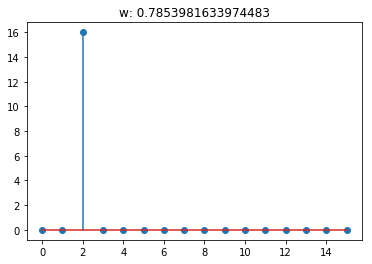

In [4]:
N = 16
f0 = 2
w0 = (2*np.pi)*f0/N % (2*np.pi)


my_signal = make_signal(w0,0,N)
my_signal_fft = np.fft.fft(my_signal)

plt.stem(np.abs(my_signal_fft))
plt.title('w: {}'.format(w0))
plt.show()

In [5]:
def omega_to_location(w,N):
    return w*(N/(2*np.pi))

In [6]:
omega_to_location(kays_method(my_signal),N)

2.0

In [7]:
from functools import reduce

In [8]:
def make_successive_estimation_sampling_chains(num_chains, 
                                               num_samples_per_chain, 
                                               N, 
                                               p=2, 
                                               random_start=False):
    """
    This function makes sampling points for successive estimation method
    """
    chains_sp = []
    
    for i in range(num_chains):
        # ith chain gets skips of p**i
        skip = p**i
        if random_start:
            start_location = np.random.choice(N)
        else:
            start_location = 0
        
        sp = np.arange(start_location, 
                       start_location+skip*num_samples_per_chain, 
                       skip)
        sp = sp % N
        chains.append(sp)
    return chains
    
    

def make_kay_chains(w0, num_chains, num_samples_per_chain, snrdb, p=2):
    """
    Function to make chains for successive estimation using Kay's method
    """
    # this is a list of arrays
    # it has num_chains many elements
    # each element is an array of length num_samples_per_chain
    chains = []
    # noise variance
    sigma2 = get_sigma2_from_snrdb(snrdb)
    
    for i in range(num_chains):
        # first chain gets samples with skipping 1
        # second chain gets samples with skipping 2, etc...
        skip = p**i
        # skip needs to be passed
        noisy_signal = make_noisy_signal(w=w0,
                                         theta=0,
                                         sigma2=sigma2,
                                         n=num_samples_per_chain,
                                         skip=skip)
        
        # append to the chain
        chains.append(noisy_signal)
    return chains

def make_our_chains(w0,
                    n,
                    num_pairs_per_chain,
                    snrdb,
                    prime_base=2,
                    num_samples_per_pair=2,
                    other_factor=1):
    '''
    n = what power of two is the signal
    '''
    # chains is a list of lists
    # it has n elements
    # each element is a list of tuples (sample1, sample2)
    chains = []
    # sampling_points is a list of lists
    # it has n elements
    # each element is a list of tuples (sampling_location_1, sampling_location_2)
    sampling_points = []
    sigma2 = get_sigma2_from_snrdb(snrdb)
    
    # you start by skipping signal_length/2
    skip = other_factor*prime_base**(n-1)
    
    for i in range(n):
        current_chain = []
        current_sampling_points = []
        
        # poisition of the first sample
        shift = 0
        for i in range(num_pairs_per_chain):
            signal = make_signal(w0,0,num_samples_per_pair,skip,shift)
            noise  = make_noise(sigma2,num_samples_per_pair)
            noisy_signal = signal + noise
            current_chain.append(tuple(noisy_signal))
            current_sampling_points.append(tuple([shift + i*skip for i in range(num_samples_per_pair)]))
            shift += 1
        chains.append(current_chain)
        sampling_points.append(current_sampling_points)
        # halve the skip
        skip /= prime_base
    return chains, sampling_points

# make chain
# make sub chains

def make_our_locations(n,
                       num_pairs_per_chain,
                       prime_base=2,
                       num_samples_per_pair=2,
                       other_factor=1):
    '''
    n = what power of two is the signal
    '''
    # chains is a list of lists
    # it has n elements
    # each element is a list of tuples (sample1, sample2)
    chains = []
    # sampling_points is a list of lists
    # it has n elements
    # each element is a list of tuples (sampling_location_1, sampling_location_2)
    sampling_points = []
    
    # you start by skipping signal_length/2
    skip = other_factor*prime_base**(n-1)
    
    for i in range(n):
        current_sampling_points = []
        
        # poisition of the first sample
        shift = 0
        for i in range(num_pairs_per_chain):
            current_sampling_points.append(tuple([shift,shift+skip]))
            shift += 1
        sampling_points.append(current_sampling_points)
        # halve the skip
        skip /= prime_base
    return sampling_points

def estimate_bit_diff(chain,
                      sampling_points,
                      ref_w0):
    '''
    chain: pairs of samples obtained from the chain
    sampling_points: the points at which the samples are obtained
    ref_w0: the reference frequency obtained so far
    '''
    # complex valued estimate of the sign
    d = 0
    # number of pairs in a chain
    len_chain = len(chain)
    # go over the chain
    for i in range(len_chain):
        # where the samples are taken
        s1,s2 = sampling_points[i]
        # the sample values
        a,b = chain[i]
        # rotate the frequency based on the reference
        a = a*np.exp(-1j*ref_w0*s1)
        b = b*np.exp(-1j*ref_w0*s2)
        # check the sign
        d += (b - a)
    # average the sign
    # (this would change if there is a covariance between estimates)
    # (we get around this by taking non-overlapping samples)
    d /= len_chain
    
    # sign (returns -1 or 1)
    estimated_sign = np.sign(np.real(d) + 1)
    
    
#     print('jump: {} - {} = {}'.format(s2,s1,s2-s1))
#     print(d + 1)
#     print('sign: {}'.format(estimated_sign))
    return estimated_sign

def estimate_bit(chain,
                 sampling_points,
                 ref_w0,
                 prime_base=2):
    '''
    chain: pairs of samples obtained from the chain
    sampling_points: the points at which the samples are obtained
    ref_w0: the reference frequency obtained so far
    p: prime that is equal to the base
    '''
    # complex valued estimate of the sign
    d = 0
    # number of pairs in a chain
    len_chain = len(chain)
    # go over the chain
    for i in range(len_chain):
        # where the samples are taken
        s1,s2 = sampling_points[i]
        # the sample values
        a,b = chain[i]
        # rotate the frequency based on the reference
        a = a*np.exp(-1j*ref_w0*s1)
        b = b*np.exp(-1j*ref_w0*s2)
        # check the sign
        d += b*np.conj(a)
    # average the sign
    # (this would change if there is a covariance between estimates)
    # (we get around this by taking non-overlapping samples)
    d /= len_chain
    
    # rotate according to decision boundaries
    # we need to rotate by 2pi/(2prime_base)
    # this is to make one of the boundaries of the
    # voronoi cells touch the positive side of x-axis
    # so we can just return the integer part of a number
    # to get the bit
    d *= np.exp(1j*np.pi/prime_base)
    # get the angle and normalize by 2pi
    angle = np.angle(d)/2/np.pi
    # angle is between (-0.5,0.5), take
    # the mod to make it between (0,1)
    angle = angle % 1
    # return which voronoi cell the angle falls into
    # it falls to gaps of 1/prime_base so multiply
    # with prime base and get the integer part
    return int(angle*prime_base)

def estimate_bit_ml(chain,
                    sampling_points,
                    ref_w0,
                    prime_base=2,
                    statistics_function=np.real):
    '''
    chain:               pairs of samples obtained from the chain
    sampling_points:     the points at which the samples are obtained
    ref_w0:              the reference frequency obtained so far
    p:                   prime that is equal to the base
    statistics_function: when we know the amplitude we can use np.real 
                         as the statistics function.  However, when the
                         coefficient is not known, we need to use np.abs
    '''
    # number of pairs in a chain
    len_chain = len(chain)
    max_inprod = -np.inf
    best_loc = 0
    
    # these were sampling_points[0] and chain[0]
    # sampling_points = np.array(sampling_points)
    # chain = np.array(chain)
    
    rotater = np.exp(-1j*ref_w0*sampling_points)
    chain = chain*rotater
    
    # go over possible bits
    t = np.arange(len(sampling_points))
    for l in range(prime_base):
        steering_vector = np.exp(-1j*2*np.pi*l*t/prime_base)
        current_inprod = chain.dot(steering_vector)
        # can we look at the real part here when we have 
        # phase in the problem or equivalently there is a
        # coefficient in front of the tone.  If we change 
        # this to abs we loose a lot of performance in terms
        # of the number of samples
        if statistics_function(current_inprod) > max_inprod:
            max_inprod = statistics_function(current_inprod)
            best_loc = l
    return int(best_loc)

def estimate_bit_sub_ml(chain,
                        sampling_points,
                        ref_w0,
                        prime_base=2,
                        summing_power=1):
    '''
    chain: signal samples (list of arrays)
    sampling_points: the points at which the samples are obtained (list of arrays)
    ref_w0: the reference frequency obtained so far
    p: prime that is equal to the base
    '''
    # here we assume there are multiple pairs per chain
    # so we cannot do single chain computation like the
    # ml version
    # this is the number of sub-chains
    len_chain = len(chain)
    max_metric = -np.inf
    best_loc = 0
    t = np.arange(len(sampling_points[0]))
    # go over possible bits
    for l in range(prime_base):
        sum_metric = 0
        steering_vector = np.exp(-1j*2*np.pi*l*t/prime_base)
        # go over the sub-chains
        for batch, sp in zip(chain,sampling_points):
            # we need to use this rotater!
            rotater = np.exp(-1j*ref_w0*sp)
            batch = batch*rotater
            current_inprod = batch.dot(steering_vector)
            sum_metric += np.abs(current_inprod)**summing_power
        
        if sum_metric > max_metric:
            max_metric = sum_metric
            best_loc = l
    return int(best_loc)

def get_correlation_with_steering_vector(yx, sp, w0, sv):
    rotater = np.exp(-1j*w0*sp)
    yx = yx*rotater
    current_inprod = yx.dot(sv)
    return current_inprod
    

def our_method(all_chains,
               all_sampling_points,
               prime_base=2,
               bin_estimator=estimate_bit):
    # start with reference 0
    ref_w0 = 0
    n = len(all_chains)
    # signal length
    N = prime_base**n
    # go over chains
    for i in range(n):
        current_chain = all_chains[i]
        current_smapling_points = all_sampling_points[i]
        # estimate the bit
        current_bit = bin_estimator(current_chain,
                                    current_smapling_points,
                                    ref_w0,
                                    prime_base)
        # if the current bit is -1 it means we are odd with
        # respect to ith bit of the frequency
        ref_w0 += current_bit*(prime_base**i)*(2*np.pi)/N
    return ref_w0

# sampler

In [9]:
class Sampler:
    def __init__(self, w, theta, sigma2):
        self.w = w
        self.theta = theta
        self.sigma2 = sigma2
        self.noise_scaling = np.sqrt(sigma2/2)
    
    def sample(self, n):
        signal = np.exp(1j*(self.w*n+ self.theta))
        noise  = noise_scaling*np.random.randn(n) + 1j*noise_scaling*np.random.randn(n)
        return signal+noise
        
class OnePeriodSampler:
    def __init__(self, w, theta, sigma2):
        self.w = w
        self.theta = theta
        self.sigma2 = sigma2
        self.noise_scaling = np.sqrt(sigma2/2)
        self.already_generated = {}
    
    def sample(self, n):
        if n in self.already_generated:
            return self.already_generated[n]
        else:
            signal = np.exp(1j*(self.w*n+ self.theta))
            noise  = noise_scaling*np.random.randn(n) + 1j*noise_scaling*np.random.randn(n)
            return signal+noise

# test 1

Here I test our algorithm under independent noise and infinite-length signal setting

In [10]:
def run_many(f, num_iter, **kwargs):
    r = []
    for i in range(num_iter):
        r.append(f(**kwargs))
    return r

In [11]:
def test_ml(p, n, samples_per_chain, f0, snrdb, statistics_function=np.real, premake=False):
    """
    Make the one with the signal pre-made.
    """
    N = p**n
    w0 = (2*np.pi)*f0/N
    s2 = get_sigma2_from_snrdb(snrdb)
    
    # this is the setting where we are given a single period from the signal
    if premake:
        x = make_noisy_signal(w0, theta=0, sigma2=s2, n=N, skip=1)
    
    c_so_far = 0
    for chain in range(n):
        skip = p**(n-1-chain)
        ref_w0 = (2*np.pi)*c_so_far/N
        if not premake:
            y = make_noisy_signal(w0, theta=0, sigma2=s2, n=samples_per_chain, skip=skip)
            sampling_points = np.arange(0, samples_per_chain*skip, skip)
        else:
            random_shift = np.random.choice(N)
            sampling_points = np.arange(random_shift, samples_per_chain*skip+random_shift, skip)
            sampling_points = sampling_points % N
            y = x[sampling_points]
            
        bit = estimate_bit_ml(y, sampling_points, ref_w0, prime_base=p, statistics_function=statistics_function)
        c_so_far += bit * (p**chain)
    
    return int(c_so_far == f0)

def test_sub_ml(p, n, samples_per_chain, num_chains, f0, snrdb, summing_power=1, alternate=False):
    N = p**n
    w0 = (2*np.pi)*f0/N
    s2 = get_sigma2_from_snrdb(snrdb)
    
    c_so_far = 0
    for chain in range(n):
        skip = p**(n-1-chain)
        ref_w0 = (2*np.pi)*c_so_far/N
        
        current_samples = []
        current_sampling_points = []
        
        # make this using map function instead to speed up the computations
        for sub_chain in range(num_chains):
            y = make_noisy_signal(w0, theta=0, sigma2=s2, n=samples_per_chain, skip=skip)
            t = np.arange(0, samples_per_chain*skip, skip)
            current_samples.append(y)
            current_sampling_points.append(t)
        
        bit = estimate_bit_sub_ml(current_samples,
                                  current_sampling_points, 
                                  ref_w0,
                                  prime_base=p,
                                  summing_power=summing_power)
        
        c_so_far += bit * (p**chain)
        
        if alternate:
            if num_chains > 2:
                num_chains = max(num_chains // 2, 1)
                samples_per_chain = samples_per_chain * 2
    
    return int(c_so_far == f0)

def test_mixed_ml(p, n, m, f0, snrdb, summing_power=1):
    """
    p:  prime factor
    n:  power of the prime
    m:  initial number of bits to recover
    f0: 
    snrdb:
    summing_power:
    """
    N = p**n
    w0 = (2*np.pi)*f0/N
    s2 = get_sigma2_from_snrdb(snrdb)
    
    c_so_far = 0
    skip = None
    num_recovered_bits = 0
    
    samples_per_chain = p**m
    
    while num_recovered_bits < n:
        if num_recovered_bits == 0:
            skip = p**(n-m)
            current_recovered_bits = m
        else:
            skip = p**(n-num_recovered_bits-1)
            current_recovered_bits = 1
            
        ref_w0 = (2*np.pi)*c_so_far/N
        
        current_samples = []
        current_sampling_points = []
        

        y = make_noisy_signal(w0, theta=0, sigma2=s2, n=samples_per_chain, skip=skip)
        t = np.arange(0, samples_per_chain*skip, skip)
        current_samples.append(y)
        current_sampling_points.append(t)
        
        bit = estimate_bit_sub_ml(current_samples,
                                  current_sampling_points, 
                                  ref_w0,
                                  prime_base=p**current_recovered_bits,
                                  summing_power=summing_power)
        
        c_so_far += bit * (p**num_recovered_bits)
        
    
        num_recovered_bits += current_recovered_bits
    return int(c_so_far == f0)

def test_kays(p, n, num_samples, f0, snrdb):
    N = p**n
    w0 = (2*np.pi)*f0/N
    s2 = get_sigma2_from_snrdb(snrdb)
    
    y = make_noisy_signal(w0, theta=0, sigma2=s2, n=num_samples, skip=1)
    freq = kays_method(y)
    
    return freq

def test_successive_estimation(p, n, samples_per_chain, num_chains, f0, snrdb, summing_power=1):
    N = p**n
    w0 = (2*np.pi)*f0/N
    s2 = get_sigma2_from_snrdb(snrdb)
    
    chains = make_kay_chains(w0, num_chains, samples_per_chain, snrdb, p=2)
    f0_hat = successive_estimation(chains, N, p=2, rounding=None)
    
    return int(f0_hat == f0)


def test_linear_ml(p, n, samples_per_chain, f0, snrdb):
    """
    Make the one with the signal pre-made.
    """
    N = p**n
    w0 = (2*np.pi)*f0/N
    s2 = get_sigma2_from_snrdb(snrdb)
    
    sampling_points = np.random.choice(N, samples_per_chain, replace=False)
    
#     sampling_points = np.arange(samples_per_chain)
    
    signal = np.exp(1j*(w0*sampling_points))
    noise  = make_noise(s2, samples_per_chain)
    noisy_signal = signal + noise
    
    y = np.zeros(N, dtype=np.complex)
    y[sampling_points] = noisy_signal
    
    v = np.fft.fft(y)
    v = np.abs(v)
    
    k_hat = np.argmax(v)
    
    return int(k_hat == f0)

In [13]:
kays_method = kays_method3

In [14]:
def calc_error(r, ref):
    angle_diff = np.angle(np.exp(1j*r)*np.conj(ref))
    return np.mean((angle_diff/2/np.pi)**2)

In [15]:
def to_db(u):
    return 10*np.log10(u)

In [16]:
def calc_acc(omegas, p, f0):
    omegas = omegas/(2*np.pi)
    omegas = (omegas+1/(p*2)) % 1
    f0_hat = np.floor(omegas*p)
    return np.mean(f0_hat == f0)
    

# fix n + change snr -> find m

In [17]:
import pandas as pd

In [ ]:
m_points = np.arange(2,64,2)
print(m_points)

In [ ]:
# p = 2
# f0 = 0
# snrdb = 0


# df_linear_ml = pd.DataFrame(columns=['n', 'samples', 'acc'])
# for n in tqdm(np.arange(20,50,5), leave=False):
#     N = p**n
#     for m in tqdm(m_points):
#         # Sub-ML multi-period
#         num_samples = m*n
#         q = run_many(test_linear_ml, 10, p=p, n=n, samples_per_chain=num_samples, f0=f0, snrdb=snrdb)
        
#         acc_hat = np.mean(q)
        
#         entry = {'n':n, 'samples':num_samples, 'acc':acc_hat}
#         df_linear_ml = df_linear_ml.append(entry, ignore_index=True)
# #         if acc_hat == 1:
# #             break

In [188]:
snrdb_points = np.arange(9,-9,-1)
print(snrdb_points)

[ 9  8  7  6  5  4  3  2  1  0 -1 -2 -3 -4 -5 -6 -7 -8]


In [189]:
del df_ml, df_kay

NameError: name 'df_kay' is not defined

In [199]:
snrdb_points = [-9,-10,-12,-15]

In [200]:
p = 2
n = 30
N = p**n
f0 = 0

try:
    df_ml
except NameError: 
    df_ml = pd.DataFrame(columns=['n', 'samples', 'acc', 'snrdb'])

mi = 46
target_acc = 0.99
    
for snrdb in tqdm(snrdb_points):
    print('-- new db --')
    acc_hat = 0
    
    is_found = False
    while not is_found:
        
        q = run_many(test_sub_ml, 5000, p=p, n=n, samples_per_chain=mi*p, num_chains=1,
                 f0=f0, snrdb=snrdb, summing_power=2, alternate=False)
        
        acc_hat_now = np.mean(q)
        
        print('mi: {} -- acc: {}'.format(mi, acc_hat_now))
        
        
        if acc_hat_now > target_acc:
            num_samples = n*p*mi
            entry = {'n':n, 'samples':num_samples, 'acc':acc_hat, 'snrdb':snrdb}
            df_ml = df_ml.append(entry, ignore_index=True)
            is_found = True
        else:
            mi += 1

-- new db --
mi: 46 -- acc: 0.9572
mi: 47 -- acc: 0.9622
mi: 48 -- acc: 0.9634
mi: 49 -- acc: 0.9692
mi: 50 -- acc: 0.9734
mi: 51 -- acc: 0.977
mi: 52 -- acc: 0.9784
mi: 53 -- acc: 0.9802
mi: 54 -- acc: 0.9826
mi: 55 -- acc: 0.9846
mi: 56 -- acc: 0.984
mi: 57 -- acc: 0.9884
mi: 58 -- acc: 0.9912
-- new db --
mi: 58 -- acc: 0.9574
mi: 59 -- acc: 0.9624
mi: 60 -- acc: 0.9614
mi: 61 -- acc: 0.9704
mi: 62 -- acc: 0.9726
mi: 63 -- acc: 0.9688
mi: 64 -- acc: 0.976
mi: 65 -- acc: 0.9778
mi: 66 -- acc: 0.9752
mi: 67 -- acc: 0.9802
mi: 68 -- acc: 0.986
mi: 69 -- acc: 0.9874
mi: 70 -- acc: 0.9888
mi: 71 -- acc: 0.9884
mi: 72 -- acc: 0.9902
-- new db --
mi: 72 -- acc: 0.849
mi: 73 -- acc: 0.8566
mi: 74 -- acc: 0.875
mi: 75 -- acc: 0.8828
mi: 76 -- acc: 0.8866
mi: 77 -- acc: 0.8886
mi: 78 -- acc: 0.887
mi: 79 -- acc: 0.904
mi: 80 -- acc: 0.9116
mi: 81 -- acc: 0.9126
mi: 82 -- acc: 0.922
mi: 83 -- acc: 0.9228
mi: 84 -- acc: 0.9246
mi: 85 -- acc: 0.9276
mi: 86 -- acc: 0.9332
mi: 87 -- acc: 0.9432
mi

In [195]:
snrdb_points = [-9,-10,-12,-15]

In [197]:
p = 2
n = 30
N = p**n
f0 = 0

try:
    df_kay
except NameError: 
    df_kay = pd.DataFrame(columns=['n', 'samples', 'acc', 'snrdb'])

lower_m = 1
target_acc = 0.99
    
for snrdb in tqdm(snrdb_points):
    print('-- new db --')
    acc_hat = 0
    
    upper_found = False
    # find lower and upper bounds
    
    mi = lower_m
    while not upper_found:
        mi *= 2
        q = run_many(test_successive_estimation, 5000, p=p, n=n,
                     samples_per_chain=mi*p, num_chains=n, f0=f0, snrdb=snrdb)
        
        print(np.mean(q))
        if np.mean(q) > target_acc:
            upper_m = mi
            lower_m = int(mi//2)
            upper_found = True
            print('upper found: {}'.format(upper_m))
    
    while upper_m - lower_m > 1:

        mid_m = int(np.ceil((upper_m + lower_m)/2))

        print('upper: {}'.format(upper_m))
        print('lower: {}'.format(lower_m))        
        print('mid: {}'.format(mid_m))
        q = run_many(test_successive_estimation, 5000, p=p, n=n,
                     samples_per_chain=mid_m*p, num_chains=n, f0=f0, snrdb=snrdb)
        
        acc_hat_now = np.mean(q)
        
        print('acc now: {}'.format(acc_hat_now))
        if acc_hat_now >= target_acc:
            upper_m = mid_m
            acc_hat = acc_hat_now
        else:
            lower_m = mid_m
    
    num_samples = n*p*upper_m
    entry = {'n':n, 'samples':num_samples, 'acc':acc_hat, 'snrdb':snrdb}
    df_kay = df_kay.append(entry, ignore_index=True)

-- new db --
0.9994
upper found: 618
upper: 618
lower: 309
mid: 464
acc now: 0.991
upper: 464
lower: 309
mid: 387
acc now: 0.9728
upper: 464
lower: 387
mid: 426
acc now: 0.9876
upper: 464
lower: 426
mid: 445
acc now: 0.9862
upper: 464
lower: 445
mid: 455
acc now: 0.9884
upper: 464
lower: 455
mid: 460
acc now: 0.9912
upper: 460
lower: 455
mid: 458
acc now: 0.9892
upper: 460
lower: 458
mid: 459
acc now: 0.9878
-- new db --
0.9988
upper found: 918
upper: 918
lower: 459
mid: 689
acc now: 0.9884
upper: 918
lower: 689
mid: 804
acc now: 0.9954
upper: 804
lower: 689
mid: 747
acc now: 0.9924
upper: 747
lower: 689
mid: 718
acc now: 0.9902
upper: 718
lower: 689
mid: 704
acc now: 0.99
upper: 704
lower: 689
mid: 697
acc now: 0.9862
upper: 704
lower: 697
mid: 701
acc now: 0.9882
upper: 704
lower: 701
mid: 703
acc now: 0.9894
-- new db --
0.9776
0.9998
upper found: 2812
upper: 2812
lower: 1406
mid: 2109
acc now: 0.997
upper: 2109
lower: 1406
mid: 1758
acc now: 0.9936
upper: 1758
lower: 1406
mid: 1582

KeyboardInterrupt: 

In [26]:
# p = 2
# n = 10
# N = p**n
# f0 = 0



# m = 2
# target_acc = 0.99

# for snrdb in tqdm(snrdb_points):
#     acc_hat = 0
#     while acc_hat < target_acc:
#         # Sub-ML multi-period
#         num_samples = m*n
        
#         q = run_many(test_successive_estimation, 5000, p=p, n=n,
#                      samples_per_chain=m, num_chains=n, f0=f0, snrdb=snrdb)
        
#         acc_hat = np.mean(q)
#         if acc_hat < target_acc:
#             m += 2
#         else:
#             entry = {'n':n, 'samples':num_samples, 'acc':np.mean(q), 'snrdb':snrdb}
#             df_kay = df_kay.append(entry, ignore_index=True)

In [201]:
df_ml.to_pickle('df_ml.pickle')

In [202]:
df_kay.to_pickle('df_kay.pickle')

In [206]:
df_ml = df_ml[df_ml['snrdb']  >= -12]

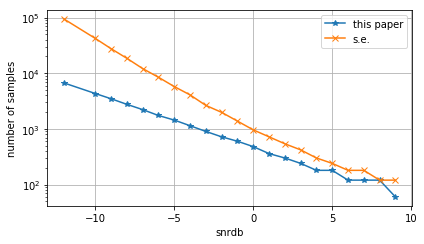

In [212]:
fig1, ax1 = plt.subplots(figsize=(6,3.5))

ax1.semilogy(df_ml['snrdb'], df_ml['samples'], '*-', label='this paper')
ax1.semilogy(df_kay['snrdb'], df_kay['samples'], 'x-', label='s.e.')

# ax1.plot(*get_samples_for_acc(df_ml, 0.99, -5), '*-', label='ours (-5dB)')
# ax1.plot(*get_samples_for_acc(df_kay, 0.99, -5), 'x-', label='s.e. (-5dB)')

# ax1.set_xscale('log', basex=2)
# ax1.set_xticks(2**np.arange(10,60,5))
# ax1.get_xaxis().set_major_formatter(LogFormatterExponent(base=2))

plt.xlabel('snrdb')
plt.ylabel('number of samples')
plt.legend()
plt.grid(which='major')
plt.tight_layout()
plt.savefig('manuscript/figures/m-vs-snr.pdf')
plt.show()

In [213]:
def write_data(outfile, column_names, *args):
    with open(outfile, 'w') as out:
        out.write(' '.join(column_names) + '\n')
        for z in zip(*args):
            z = [str(zi) for zi in z]
            out.write(' '.join(z))
            out.write('\n')

In [214]:
write_data('m-vs-snr.txt', ['snrdb', 'ml', 'kay'], df_ml['snrdb'], df_ml['samples'], df_kay['samples'])